# Example for over-/underfitting and regularization

In [7]:
from __future__ import print_function  # for backwards compatibility: uses print() also in python2

import torch
import torch.nn as nn  # nn functionality
from torch.autograd import Variable  # backpropagation
import torch.optim as optim  # optimizers
import numpy as np
import math

import matplotlib as mpl  # for plotting
%matplotlib inline
import matplotlib.pyplot as plt  # for plotting
from matplotlib.colors import LinearSegmentedColormap  # some colors for  plotting the different data ranges
plt.rc('text', usetex=True)  # LaTex support for captions

# Optional: Seed the random number generator for reproducibility
seed = 0
np.random.seed(seed)
rng = np.random.RandomState(seed)

## Generate an example set of points

In [8]:
# helper function to create random batches
def shuffle_trainset(x_train, y_train):
    assert len(x_train) == len(y_train)
    new_order = np.random.permutation(len(x_train))
    new_x = [x_train[i] for i in new_order]
    new_y = [y_train[i] for i in new_order]

    return new_x, new_y


# the function we will interpolate: A Gaussian with small sinusoidal modulations
def f(x):
    random_noise = 0.6 * np.random.random() - 0.3  # generate a random number in [-0.3, 0.3)
    return 0.02 * math.sin(3. * x) + math.exp(-(x - random_noise)**2/2.)


x_train = [[x] for x in np.arange(-5, 5, .5)]
y_train = [[f(x[0])] for x in x_train]
x_test = Variable(torch.from_numpy(np.array([[x] for x in np.arange(-7,7,0.05)], dtype=np.float32)))

## Define the NN hyperparameters

In [9]:
# number of nodes in each layer
input_dim = 1
hidden1_dim = 15
hidden2_dim = 15
output_dim = 1

# set training variables
epochs = 10
batch_size = 8
learning_rate = 0.01

## 1.) Set up and initialize the NN, no regularization, undertraining


Start undertraining...

Undertraining complete!


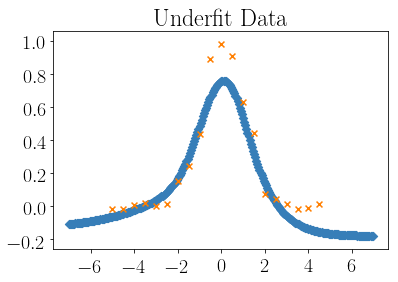

In [10]:
# create the NNs
nn_regressor = torch.nn.Sequential(
    torch.nn.Linear(input_dim, hidden1_dim),
    torch.nn.Tanh(),
    torch.nn.Linear(hidden1_dim, hidden2_dim),
    torch.nn.Tanh(),
    torch.nn.Linear(hidden2_dim, output_dim),
)

# Specify the optimizer: ADAM with MSE loss
optimizer = optim.Adam(nn_regressor.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

# undertrain the NN
nn_regressor.train()  # set to training mode, i.e. activate dropout, etc.
print("\nStart undertraining...")

for epoch in range(epochs):
    optimizer.zero_grad()  # reset the gradient for new batch
    batches = int(np.floor(len(x_train) / batch_size))
    x_train, y_train = shuffle_trainset(x_train, y_train)
    for batch in range(batches):
        # wrap around for last batch if batch size is smaller than the number of elements left
        if len(x_train) < (batch + 1) * batch_size:
            x_batch = x_train[batch * batch_size:] + x_train[0:len(x_train) - batch * batch_size:]
            y_batch = y_train[batch * batch_size:] + y_train[0:len(y_train) - batch * batch_size:]
        else:
            x_batch = x_train[batch * batch_size:(batch + 1) * batch_size]
            y_batch = y_train[batch * batch_size:(batch + 1) * batch_size]

        x_batch = Variable(torch.from_numpy(np.array(x_batch, dtype=np.float32)))
        y_batch = Variable(torch.from_numpy(np.array(y_batch, dtype=np.float32)))

        y_hat = nn_regressor(x_batch)  # forward pass
        loss = criterion(y_hat, y_batch)  # compute loss
        loss.backward()  # backward pass
        optimizer.step()  # update parameters

print("\nUndertraining complete!")

# Regression with the undertrained NN: find predictions on a finer interval
nn_regressor.eval()  # set to eval mode, i.e. deactivate dropout, etc.
underfit_data = nn_regressor(x_test)

# plot the result
colors = ['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00']
cm = LinearSegmentedColormap.from_list("my_cmap", colors, N=len(colors))

# plot original plus underfit data
# extrapolated data
plt.scatter(x_test.data.numpy().flatten(), underfit_data.data.numpy().flatten(), facecolor=colors[0], s=35, marker='D')
# original data
plt.scatter([x[0] for x in x_train], [y[0] for y in y_train], facecolor=colors[1], s=35, marker='x')
plt.title(r"$\mathrm{Underfit~Data}$", size=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# plt.gca().set_aspect(0.1)
plt.show()

## 2.) Set up and initialize the NN, no regularization, overtraining


Start overtraining...

Overtraining complete!


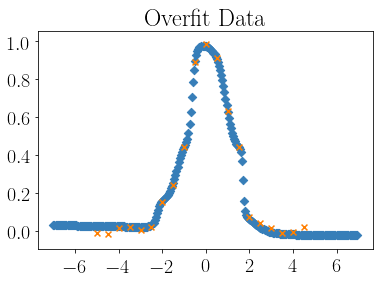

In [11]:
# create the NNs
nn_regressor = torch.nn.Sequential(
    torch.nn.Linear(input_dim, hidden1_dim),
    torch.nn.Tanh(),
    torch.nn.Linear(hidden1_dim, hidden2_dim),
    torch.nn.Tanh(),
    torch.nn.Linear(hidden2_dim, output_dim),
)

# Specify the optimizer: ADAM with MSE loss
optimizer = optim.Adam(nn_regressor.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

# set training variables
epochs = 20000
batch_size = 8
learning_rate = 0.001

# overtrain the NN
nn_regressor.train()  # set to training mode, i.e. activate dropout, etc.
print("\nStart overtraining...")

for epoch in range(epochs):
    optimizer.zero_grad()  # reset the gradient for new batch
    batches = int(np.floor(len(x_train) / batch_size))
    x_train, y_train = shuffle_trainset(x_train, y_train)
    for batch in range(batches):
        # wrap around for last batch if batch size is smaller than the number of elements left
        if len(x_train) < (batch + 1) * batch_size:
            x_batch = x_train[batch * batch_size:] + x_train[0:len(x_train) - batch * batch_size:]
            y_batch = y_train[batch * batch_size:] + y_train[0:len(y_train) - batch * batch_size:]
        else:
            x_batch = x_train[batch * batch_size:(batch + 1) * batch_size]
            y_batch = y_train[batch * batch_size:(batch + 1) * batch_size]

        x_batch = Variable(torch.from_numpy(np.array(x_batch, dtype=np.float32)))
        y_batch = Variable(torch.from_numpy(np.array(y_batch, dtype=np.float32)))

        y_hat = nn_regressor(x_batch)  # forward pass
        loss = criterion(y_hat, y_batch)  # compute loss
        loss.backward()  # backward pass
        optimizer.step()  # update parameters

print("\nOvertraining complete!")

# Regression with the undertrained NN: find predictions on a finer interval
nn_regressor.eval()  # set to eval mode, i.e. deactivate dropout, etc.
overfit_data = nn_regressor(x_test)

# plot original plus overfit data
# extrapolated data
plt.scatter(x_test.data.numpy().flatten(), overfit_data.data.numpy().flatten(), facecolor=colors[0], s=35, marker='D')
# original data
plt.scatter([x[0] for x in x_train], [y[0] for y in y_train], facecolor=colors[1], s=35, marker='x')
plt.title(r"$\mathrm{Overfit~Data}$", size=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# plt.gca().set_aspect(0.1)
plt.show()

## 3.) Set up and initialize the NN, dropout regularization, attempt overtraining


Start overtraining with dropout...

Overtraining with dropout complete!


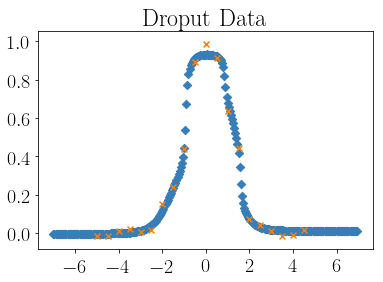

In [13]:
# create the NNs
nn_regressor = torch.nn.Sequential(
    torch.nn.Linear(input_dim, hidden1_dim),
    torch.nn.Tanh(),
    torch.nn.Dropout(0.1),
    torch.nn.Linear(hidden1_dim, hidden2_dim),
    torch.nn.Tanh(),
    torch.nn.Dropout(0.1),
    torch.nn.Linear(hidden2_dim, output_dim),
)

# Specify the optimizer: ADAM with MSE loss
optimizer = optim.Adam(nn_regressor.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

# set training variables
epochs = 20000
batch_size = 8
learning_rate = 0.001

# overtrain the NN
nn_regressor.train()  # set to training mode, i.e. activate dropout, etc.
print("\nStart overtraining with dropout...")

for epoch in range(epochs):
    optimizer.zero_grad()  # reset the gradient for new batch
    batches = int(np.floor(len(x_train) / batch_size))
    x_train, y_train = shuffle_trainset(x_train, y_train)
    for batch in range(batches):
        # wrap around for last batch if batch size is smaller than the number of elements left
        if len(x_train) < (batch + 1) * batch_size:
            x_batch = x_train[batch * batch_size:] + x_train[0:len(x_train) - batch * batch_size:]
            y_batch = y_train[batch * batch_size:] + y_train[0:len(y_train) - batch * batch_size:]
        else:
            x_batch = x_train[batch * batch_size:(batch + 1) * batch_size]
            y_batch = y_train[batch * batch_size:(batch + 1) * batch_size]

        x_batch = Variable(torch.from_numpy(np.array(x_batch, dtype=np.float32)))
        y_batch = Variable(torch.from_numpy(np.array(y_batch, dtype=np.float32)))

        y_hat = nn_regressor(x_batch)  # forward pass
        loss = criterion(y_hat, y_batch)  # compute loss
        loss.backward()  # backward pass
        optimizer.step()  # update parameters

print("\nOvertraining with dropout complete!")

# Regression with the undertrained NN: find predictions on a finer interval
nn_regressor.eval()  # set to eval mode, i.e. deactivate dropout, etc.
dropout_data = nn_regressor(x_test)

# plot original plus dropout data
# extrapolated data
plt.scatter(x_test.data.numpy().flatten(), dropout_data.data.numpy().flatten(), facecolor=colors[0], s=35, marker='D')
# original data
plt.scatter([x[0] for x in x_train], [y[0] for y in y_train], facecolor=colors[1], s=35, marker='x')
plt.title(r"$\mathrm{Droput~Data}$", size=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# plt.gca().set_aspect(0.1)
plt.show()

## 4.) Set up and initialize the NN, weight regularization, attempt overtraining


Start overtraining with weight regularization...

Overtraining with weight regularization complete!


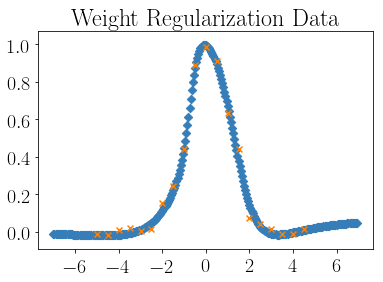

In [14]:
# create the NNs
nn_regressor = torch.nn.Sequential(
    torch.nn.Linear(input_dim, hidden1_dim),
    torch.nn.Tanh(),
    torch.nn.Linear(hidden1_dim, hidden2_dim),
    torch.nn.Tanh(),
    torch.nn.Linear(hidden2_dim, output_dim),
)

# Specify the optimizer: ADAM with MSE loss
optimizer = optim.Adam(nn_regressor.parameters(), lr=learning_rate, weight_decay=0.0001)
criterion = nn.MSELoss()

# set training variables
epochs = 20000
batch_size = 8
learning_rate = 0.001

# overtrain the NN
nn_regressor.train()  # set to training mode, i.e. activate dropout, etc.
print("\nStart overtraining with weight regularization...")

for epoch in range(epochs):
    optimizer.zero_grad()  # reset the gradient for new batch
    batches = int(np.floor(len(x_train) / batch_size))
    x_train, y_train = shuffle_trainset(x_train, y_train)
    for batch in range(batches):
        # wrap around for last batch if batch size is smaller than the number of elements left
        if len(x_train) < (batch + 1) * batch_size:
            x_batch = x_train[batch * batch_size:] + x_train[0:len(x_train) - batch * batch_size:]
            y_batch = y_train[batch * batch_size:] + y_train[0:len(y_train) - batch * batch_size:]
        else:
            x_batch = x_train[batch * batch_size:(batch + 1) * batch_size]
            y_batch = y_train[batch * batch_size:(batch + 1) * batch_size]

        x_batch = Variable(torch.from_numpy(np.array(x_batch, dtype=np.float32)))
        y_batch = Variable(torch.from_numpy(np.array(y_batch, dtype=np.float32)))

        y_hat = nn_regressor(x_batch)  # forward pass
        loss = criterion(y_hat, y_batch)  # compute loss
        loss.backward()  # backward pass
        optimizer.step()  # update parameters

print("\nOvertraining with weight regularization complete!")

# Regression with the undertrained NN: find predictions on a finer interval
nn_regressor.eval()  # set to eval mode, i.e. deactivate dropout, etc.
weightRegularized_data = nn_regressor(x_test)

# plot original plus weight-regularized data
# extrapolated data
plt.scatter(x_test.data.numpy().flatten(), weightRegularized_data.data.numpy().flatten(), facecolor=colors[0], s=35, marker='D')
# original data
plt.scatter([x for x in x_train], [y for y in y_train], facecolor=colors[1], s=35, marker='x')
plt.title(r"$\mathrm{Weight~Regularization~Data}$", size=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# plt.gca().set_aspect(0.1)
plt.show()